In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint 
import re
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors



In [2]:
track_data = pd.read_csv('misc/processed_music_info.csv')
track_lyrics = pd.read_csv('misc/track_lyrics.csv')

In [3]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23584 entries, 0 to 23583
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          23584 non-null  object 
 1   name              23584 non-null  object 
 2   artist            23584 non-null  object 
 3   spotify_id        23584 non-null  object 
 4   tags              23083 non-null  object 
 5   year              23584 non-null  int64  
 6   duration_ms       23584 non-null  int64  
 7   danceability      23584 non-null  float64
 8   energy            23584 non-null  float64
 9   key               23584 non-null  int64  
 10  loudness          23584 non-null  float64
 11  mode              23584 non-null  int64  
 12  speechiness       23584 non-null  float64
 13  acousticness      23584 non-null  float64
 14  instrumentalness  23584 non-null  float64
 15  liveness          23584 non-null  float64
 16  valence           23584 non-null  float6

In [4]:
track_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23584 entries, 0 to 23583
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   track_id  23584 non-null  object
 1   lyrics    23584 non-null  object
dtypes: object(2)
memory usage: 368.6+ KB


In [5]:
track_ids_exist = track_data['track_id'].isin(track_lyrics['track_id'])
all_track_ids_exist = track_ids_exist.all()
if not all_track_ids_exist:
	print('Some track ids do not exist in track_lyrics')
	print(track_data[~track_ids_exist])

In [6]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)
    text = text.replace("|||", " ")
    return text.strip()

track_lyrics['lyrics'] = track_lyrics['lyrics'].apply(clean_text)

In [7]:
track_lyrics.head()

,track_id,lyrics
0,TRIOREW128F424EAF0,Verse 1 Comin out of my cage and I ve been do...
1,TRRIVDJ128F429B0E8,Verse 1 Today is gonna be the day that they re...
2,TRXOGZT128F424AD74,Verse 1 Karma police arrest this man He talks...
3,TRUJIIV12903CA8848,Verse 1 The lights go out and I can t be save...
4,TRIODZU128E078F3E2,Verse 1 Sometimes I feel like I don t have a p...


In [38]:
import os
from sentence_transformers import SentenceTransformer, models
from torch import nn

saved_transformer_path = 'misc/sentence_transformer'
saved_embeddings_path = 'misc/lyrics_embeddings.npy'
saved_embeddings_3d_path = 'misc/lyrics_embeddings_3d.npy'

if os.path.exists(saved_transformer_path):
	model = SentenceTransformer(saved_transformer_path)
else:
	word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=150)
	pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
	dense_model = models.Dense(
		in_features=pooling_model.get_sentence_embedding_dimension(),
		out_features=150,
		activation_function=nn.Tanh(),
	)
	model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])
	
	model.save(saved_transformer_path)

model = SentenceTransformer.load('misc/sentence_transformer')

In [9]:
if os.path.exists(saved_embeddings_path):
	lyrics_embeddings = np.load(saved_embeddings_path)
else:
	lyrics_embeddings = model.encode(track_lyrics['lyrics'], show_progress_bar=True)
	np.save('misc/lyrics_embeddings.npy', lyrics_embeddings)

In [10]:
lyrics_embeddings.shape

(23584, 150)

In [11]:
pprint.pprint(lyrics_embeddings[3])

array([-2.68854499e-01,  2.90472537e-01, -2.56407171e-01,  3.43464687e-02,
        2.58863240e-01,  4.96621095e-02,  2.45973200e-01, -2.75245249e-01,
       -1.15612954e-01, -3.35117012e-01,  1.10348791e-01, -2.46702492e-01,
       -2.73228377e-01, -1.80323452e-01,  9.44522545e-02, -3.30335982e-02,
       -2.26769477e-01, -1.53264210e-01, -1.31785080e-01,  1.73691303e-01,
        1.76699936e-01,  1.85459852e-04,  2.27226187e-02, -3.49601060e-01,
       -1.07517920e-01, -3.93568784e-01, -2.40706384e-01, -1.46749437e-01,
        1.24819495e-01,  6.87854588e-02,  1.19947800e-02, -1.16519734e-01,
        1.42121553e-01, -2.35914677e-01,  6.81149662e-02, -9.34779353e-04,
        3.71937394e-01,  1.14400640e-01, -2.23650578e-02,  1.24644414e-01,
       -1.73458681e-01, -3.38687599e-01,  2.54873931e-01, -1.87753245e-01,
        3.73917758e-01, -2.13723555e-01,  1.29274905e-01,  1.81778565e-01,
        1.55518219e-01,  2.91321754e-01, -2.26969435e-03,  1.28606096e-01,
       -4.74544391e-02, -

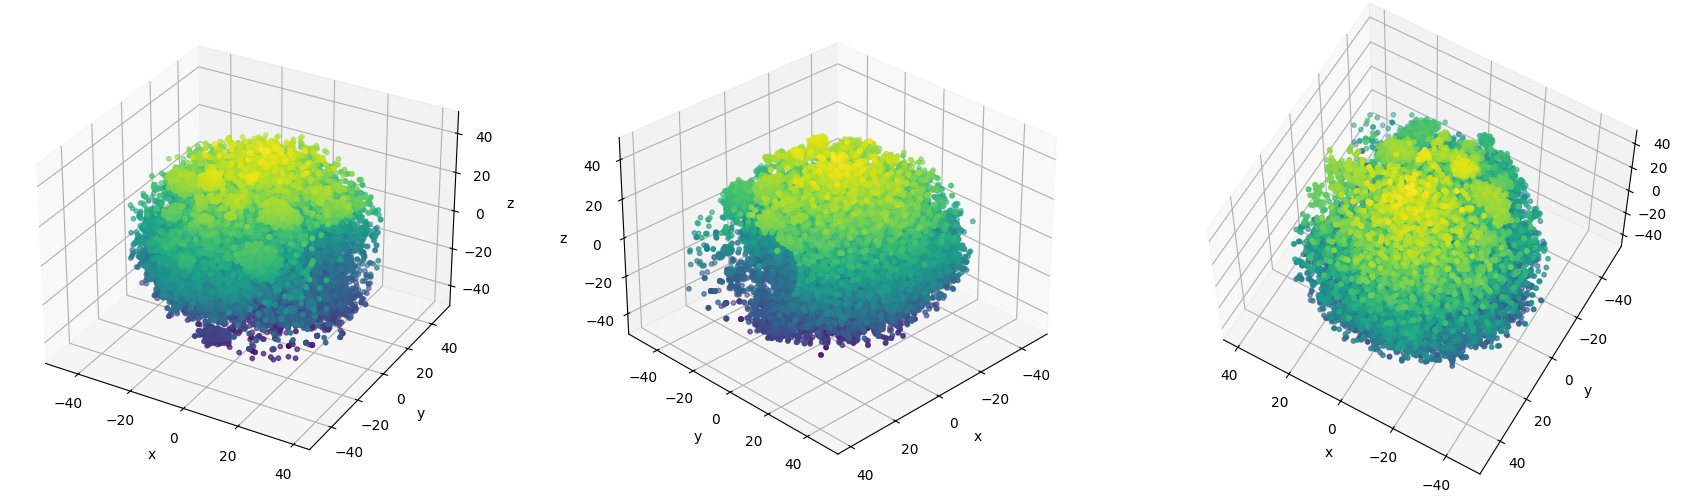

In [39]:
if os.path.exists(saved_embeddings_3d_path):
	embeddings_3d = np.load(saved_embeddings_3d_path)
else:
	tsne = TSNE(n_components=3, random_state=42)
	embeddings_3d = tsne.fit_transform(lyrics_embeddings)

fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=embeddings_3d[:, 2], s=10)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=embeddings_3d[:, 2], s=10)
ax2.view_init(elev=30, azim=45)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=embeddings_3d[:, 2], s=10)
ax3.view_init(elev=60, azim=120)  
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.tight_layout()
plt.show()


In [36]:
np.save('misc/lyrics_embeddings_3d.npy', embeddings_3d)

In [40]:

random_index = np.random.randint(0, len(embeddings_3d))

nn_model = NearestNeighbors(n_neighbors=6)
nn_model.fit(embeddings_3d)

distances, indices = nn_model.kneighbors(embeddings_3d[random_index].reshape(1, -1))

nearest_indices = indices[0][1:]
nearest_indices = np.insert(nearest_indices, 0, random_index)

print("target song:", random_index)
track_data.iloc[nearest_indices][['name', 'artist', 'year', 'loudness', 'danceability', 'liveness', 'tags']]

target song: 7083


,name,artist,year,loudness,danceability,liveness,tags
7083,Chant for Eschaton 2000,Behemoth,2011,-3.960,0.151,0.2100,"black_metal, death_metal, polish"
19003,Press Hold,Johnossi,2006,-5.400,0.408,0.0359,"rock, alternative, indie, swedish"
1393,Cuckoo Cuckoo,Animal Collective,2007,-5.507,0.164,0.1180,"electronic, experimental, psychedelic, piano, ..."
4002,Slowly Surely,Jill Scott,2000,-10.512,0.632,0.0715,"jazz, soul"
20229,Barricades in Time,Adema,2005,-3.702,0.407,0.1200,"rock, nu_metal"
16017,Hole in One,Desaparecidos,2002,-7.043,0.331,0.7160,"indie, indie_rock, emo, love, guitar, noise"
